# Explore pyiron-like workflows

**Aim:** Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

# import sys
# from pathlib import Path
# sys.path.insert(0, str(Path(Path.cwd()).parent))

import matplotlib.pylab as plt

In [2]:
from pyiron_workflow import Workflow   

import pyiron_nodes as pn

### Create structure and list available potentials

In [3]:
wf = Workflow('Lammps')
wf.structure = pn.atomistic.structure.build.Bulk('Al', cubic=True)
wf.repeat = pn.atomistic.structure.transform.Repeat(structure=wf.structure, repeat_scalar=3)
wf.list_potentials = pn.atomistic.engine.lammps.ListPotentials(structure=wf.repeat) 
    
out = wf.list_potentials.pull()
out[:5]


['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [4]:
wf.draw();

### Run a lammps job at the lowest level (close to manual run)

In [5]:
from pyiron_contrib.tinybase.shell import ExecutablePathResolver

In [6]:
T = 300

wf = Workflow('Lammps')
wf.structure = pn.atomistic.structure.build.Bulk('Al', cubic=True)
wf.repeat = pn.atomistic.structure.transform.Repeat(structure=wf.structure, repeat_scalar=3)

wf.md_input = pn.atomistic.calculator.data.InputCalcMD(temperature=T, n_ionic_steps=10_000)
wf.calculator = pn.atomistic.engine.lammps.Calc(wf.md_input)
wf.potential = pn.atomistic.engine.lammps.Potential(
    structure=wf.structure, name='1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1'
)

wf.init_lammps = pn.atomistic.engine.lammps.InitLammps(
        structure=wf.repeat,
        potential=wf.potential,
        calculator=wf.calculator,
        working_directory="test2",
    )

wf.shell = pn.atomistic.engine.lammps.Shell(
        # command=ExecutablePathResolver(module="lammps", code="lammps").path(),
        working_directory=wf.init_lammps,
    )

wf.ParseLogFile = pn.atomistic.engine.lammps.ParseLogFile(
    log_file=wf.shell.outputs.log
)
wf.ParseDumpFile = pn.atomistic.engine.lammps.ParseDumpFile(
    dump_file=wf.shell.outputs.dump
)
wf.Collect = pn.atomistic.engine.lammps.Collect(
    out_dump=wf.ParseDumpFile.outputs.dump,
    out_log=wf.ParseLogFile.outputs.log,
    calc_mode='md',
)

out = wf.run()

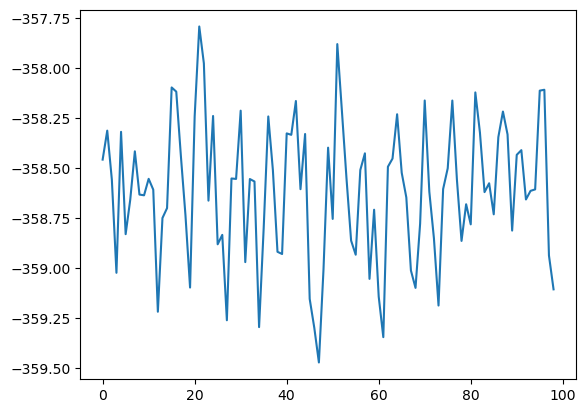

In [7]:
plt.plot(wf.Collect.outputs.generic.value.energies_pot[2:]);

### MD over list of temperatures using lammps macro

CPU times: user 315 ms, sys: 50.1 ms, total: 365 ms
Wall time: 2.3 s


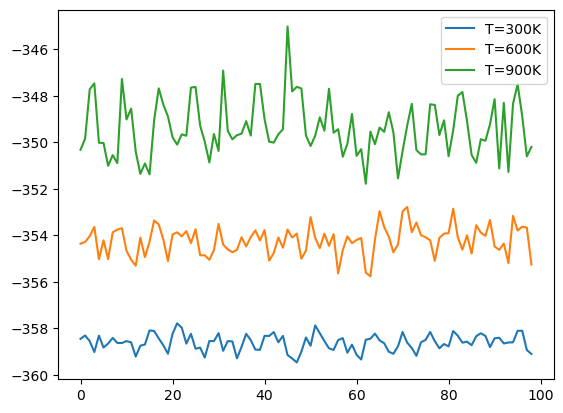

In [8]:
%%time
potential='1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1'
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    wf.structure = pn.atomistic.structure.build.Bulk('Al', cubic=True)
    wf.repeat = pn.atomistic.structure.transform.Repeat(structure=wf.structure, repeat_scalar=3)

    wf.calculator = pn.atomistic.calculator.data.InputCalcMD(temperature=T, n_ionic_steps=10_000)
    wf.lammps = pn.atomistic.engine.lammps.Code(structure=wf.repeat, 
                                            potential=potential, 
                                            calculator=wf.calculator)
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energies_pot[2:], label=f'T={T}K')
plt.legend();    

In [9]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [10]:
from pyiron_workflow import as_macro_node, Macro

In [11]:
@as_macro_node('lammps')
def energy_at_volume(wf: Macro, element: str, strain: int | float):
    wf.bulk = pn.atomistic.structure.build.Bulk(element, cubic=True)
    wf.repeat = pn.atomistic.structure.transform.Repeat(structure = wf.bulk, repeat_scalar=1)
    wf.apply_strain = pn.atomistic.structure.transform.ApplyStrain(structure=wf.repeat, strain=strain)
    
    
    wf.lammps = pn.atomistic.engine.lammps.Code(structure=wf.apply_strain, potential=potential)
    
    return wf.lammps

In [12]:
energy_at_volume(element='Al', strain=0.2).run().lammps.energies_pot[-1]

-10.1276865564986

CPU times: user 1.9 s, sys: 457 ms, total: 2.36 s
Wall time: 6.37 s


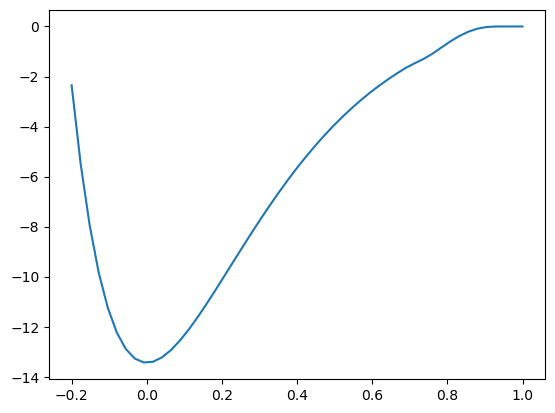

In [13]:
%%time

import numpy as np

energy_pot = []
strain_lst = np.linspace(-0.2 , 1, 51)
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out.lammps.energies_pot[0])  

plt.plot(strain_lst, energy_pot);

In [14]:
out

{'lammps': OutputCalcMD(energies_pot=array([0]), energies_kin=array([0]), forces=array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]), positions=None, temperatures=None)}

In [15]:
wf.draw();